In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import numpy as np
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from nltk.tokenize import word_tokenize
import re
import warnings
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
from sklearn.metrics import confusion_matrix
from textblob import TextBlob


nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')

stop = set(stopwords.words('english'))
warnings.filterwarnings("ignore")
%matplotlib inline


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\nicol\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\nicol\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\nicol\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
train_df = pd.read_csv("train.csv")
train_df.head()


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [3]:
test_df = pd.read_csv("test.csv")
test_df.head()



,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


## Analyse des données

In [4]:
print('Train Data size :{}'.format(train_df.shape))
print('Test Data size :{}'.format(test_df.shape))

Train Data size :(7613, 5)
Test Data size :(3263, 4)


In [5]:
train_df.isna().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [6]:
test_df.isna().sum()


id             0
keyword       26
location    1105
text           0
dtype: int64

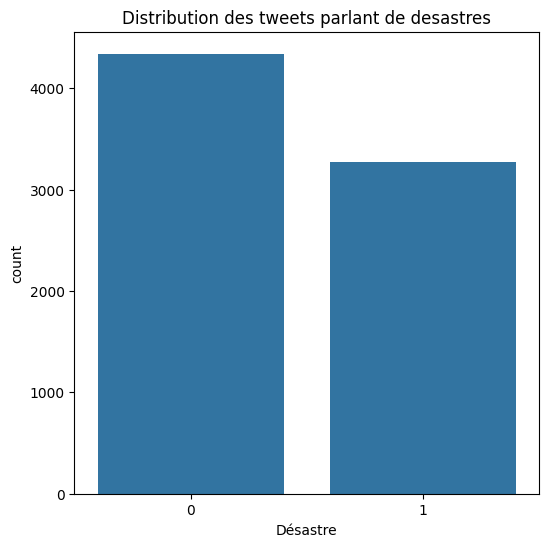

In [7]:
#Target Distribution
plt.figure(figsize=(6, 6))
#afficher les desastres en rouge et renomer target en disaster
sns.countplot(x='target', data=train_df)
plt.xlabel('Désastre')
plt.title('Distribution des tweets parlant de desastres')
plt.show()

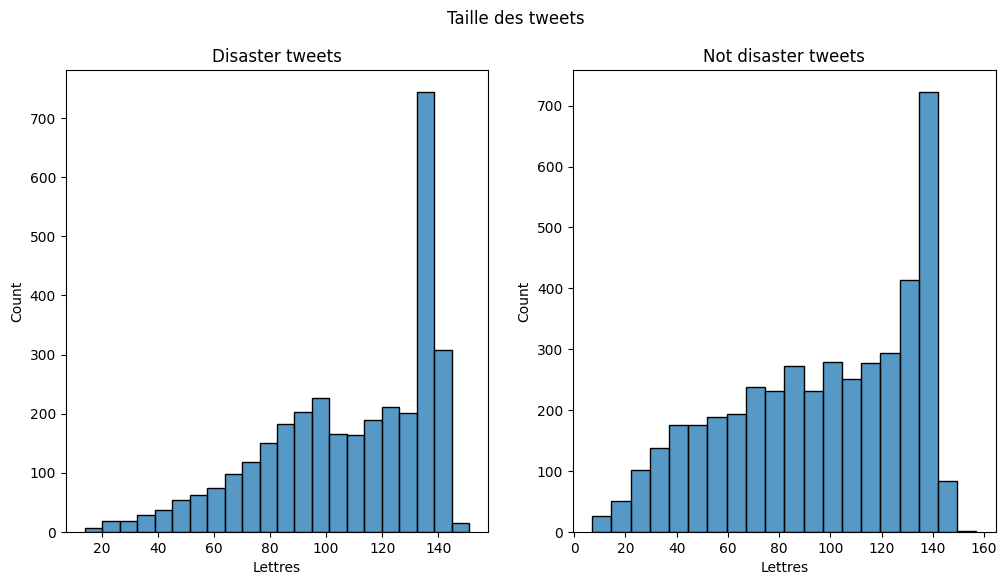

In [8]:
# Création de la figure et des sous-graphiques
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
for ax in axes:
    ax.set_xlabel('Lettres')
# Distribution de la longueur des caractères pour la classe 1
char_len_1 = train_df[train_df['target'] == 1]['text'].str.len()
sns.histplot(char_len_1, ax=axes[0], kde=False)

# Distribution de la longueur des caractères pour la classe 0
char_len_0 = train_df[train_df['target'] == 0]['text'].str.len()
sns.histplot(char_len_0, ax=axes[1], kde=False)

axes[0].set_title('Disaster tweets')
axes[1].set_title('Not disaster tweets')
fig.suptitle('Taille des tweets')
# Affichage
plt.show()

Number of words in a tweet

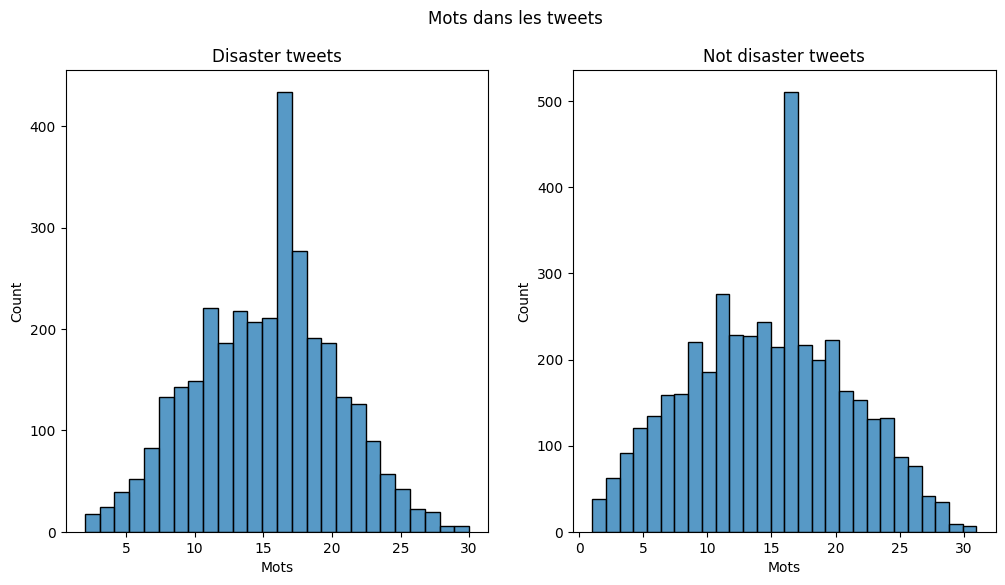

In [9]:
# Création de la figure et des sous-graphiques
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
for ax in axes:
    ax.set_xlabel('Mots')
# Distribution de la longueur des caractères pour la classe 1
char_len_1 = train_df[train_df['target'] == 1]['text'].str.split().map(lambda x: len(x))
sns.histplot(char_len_1, ax=axes[0], kde=False)

# Distribution de la longueur des caractères pour la classe 0
char_len_0 = train_df[train_df['target'] == 0]['text'].str.split().map(lambda x: len(x))
sns.histplot(char_len_0, ax=axes[1], kde=False)
axes[0].set_title('Disaster tweets')
axes[1].set_title('Not disaster tweets')
fig.suptitle('Mots dans les tweets')

# Affichage
plt.show()

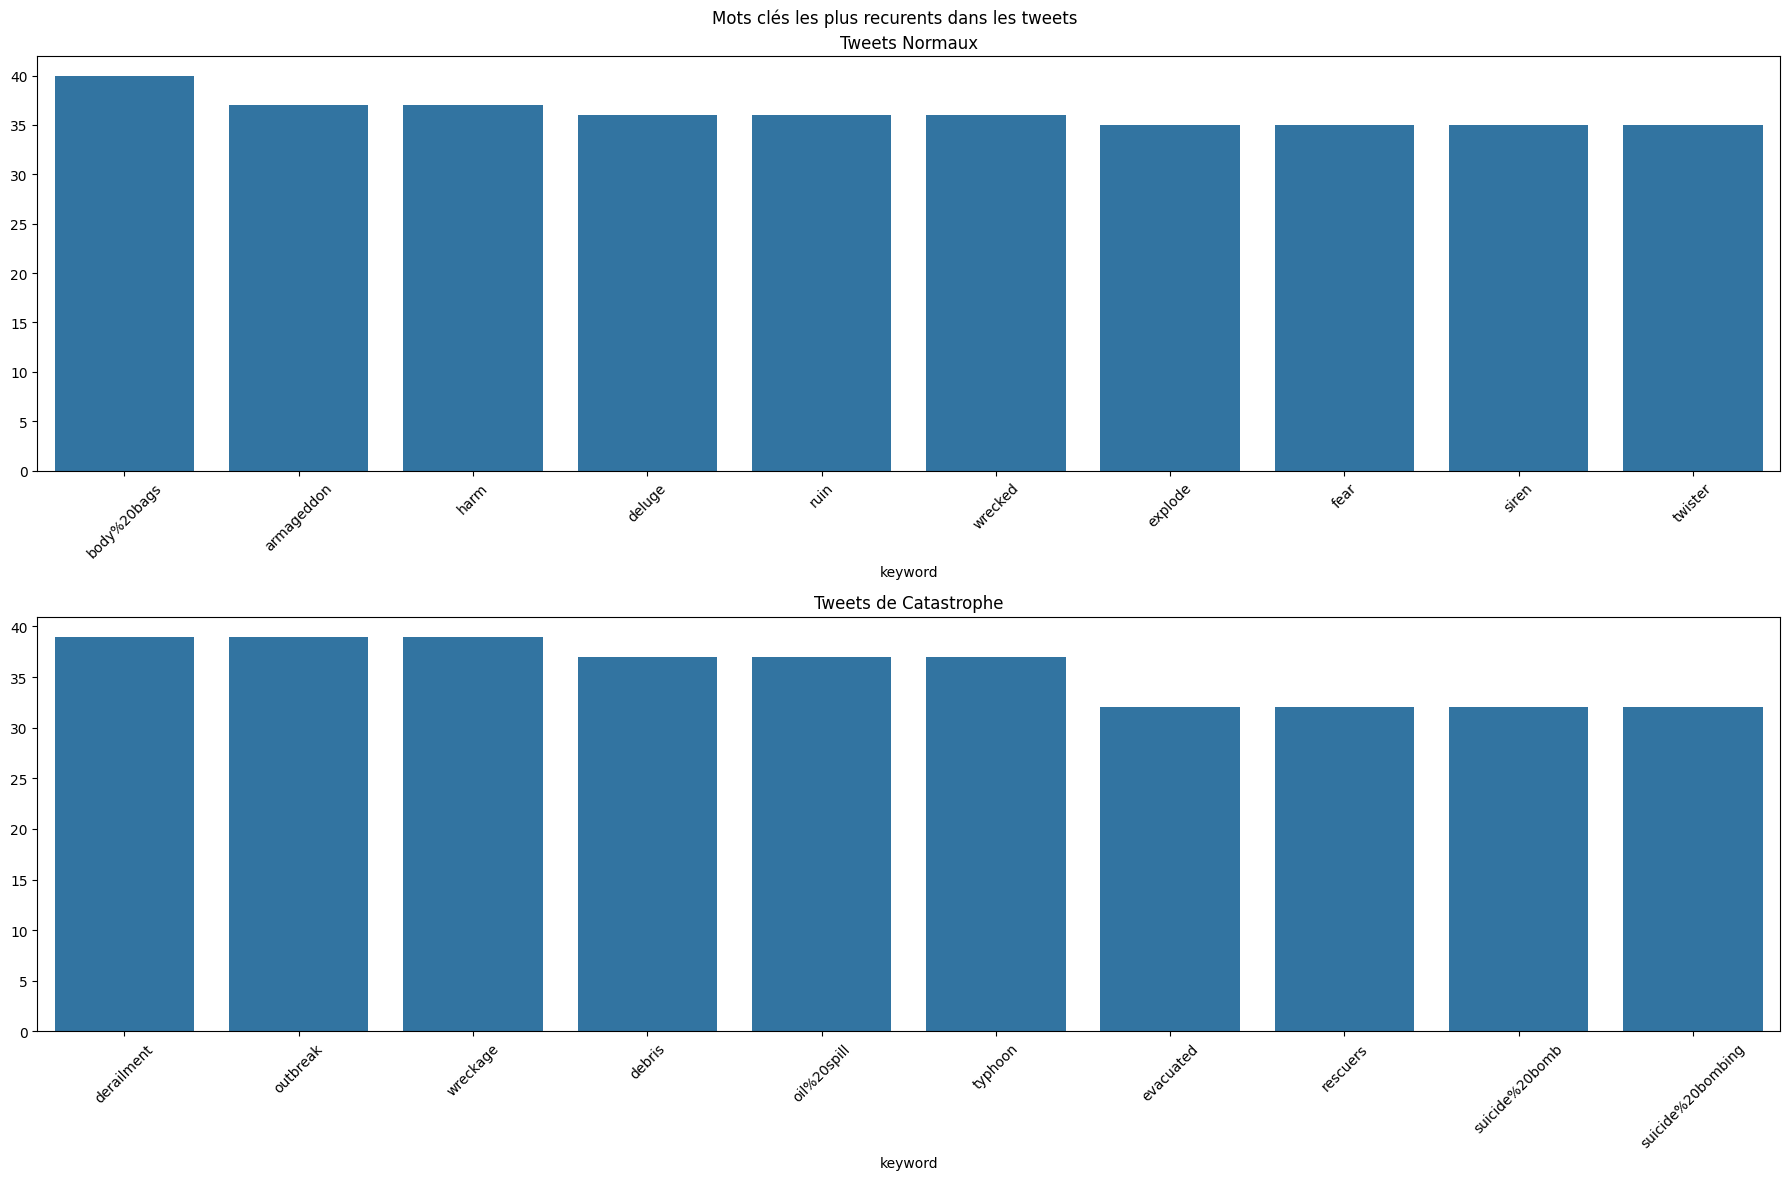

In [10]:
# Création de la figure et des sous-graphiques
fig, axes = plt.subplots(2, 1, figsize=(18, 12))

# Tracé des graphiques pour les tweets normaux
temp_normal = train_df[train_df['target'] == 0].groupby('keyword')['id'].count().nlargest(10)
sns.barplot(x=temp_normal.index, y=temp_normal.values, ax=axes[0]).set_title('Tweets Normaux')

# Tracé des graphiques pour les tweets de catastrophe
temp_disaster = train_df[train_df['target'] == 1].groupby('keyword')['id'].count().nlargest(10)
sns.barplot(x=temp_disaster.index, y=temp_disaster.values, ax=axes[1]).set_title('Tweets de Catastrophe')

# Rotation des étiquettes sur l'axe x pour une meilleure lisibilité
axes[0].tick_params(axis='x', rotation=45)
axes[1].tick_params(axis='x', rotation=45)
fig.suptitle('Mots clés les plus recurents dans les tweets')

# Affichage des graphiques
plt.tight_layout()
plt.show()

Hash Tags


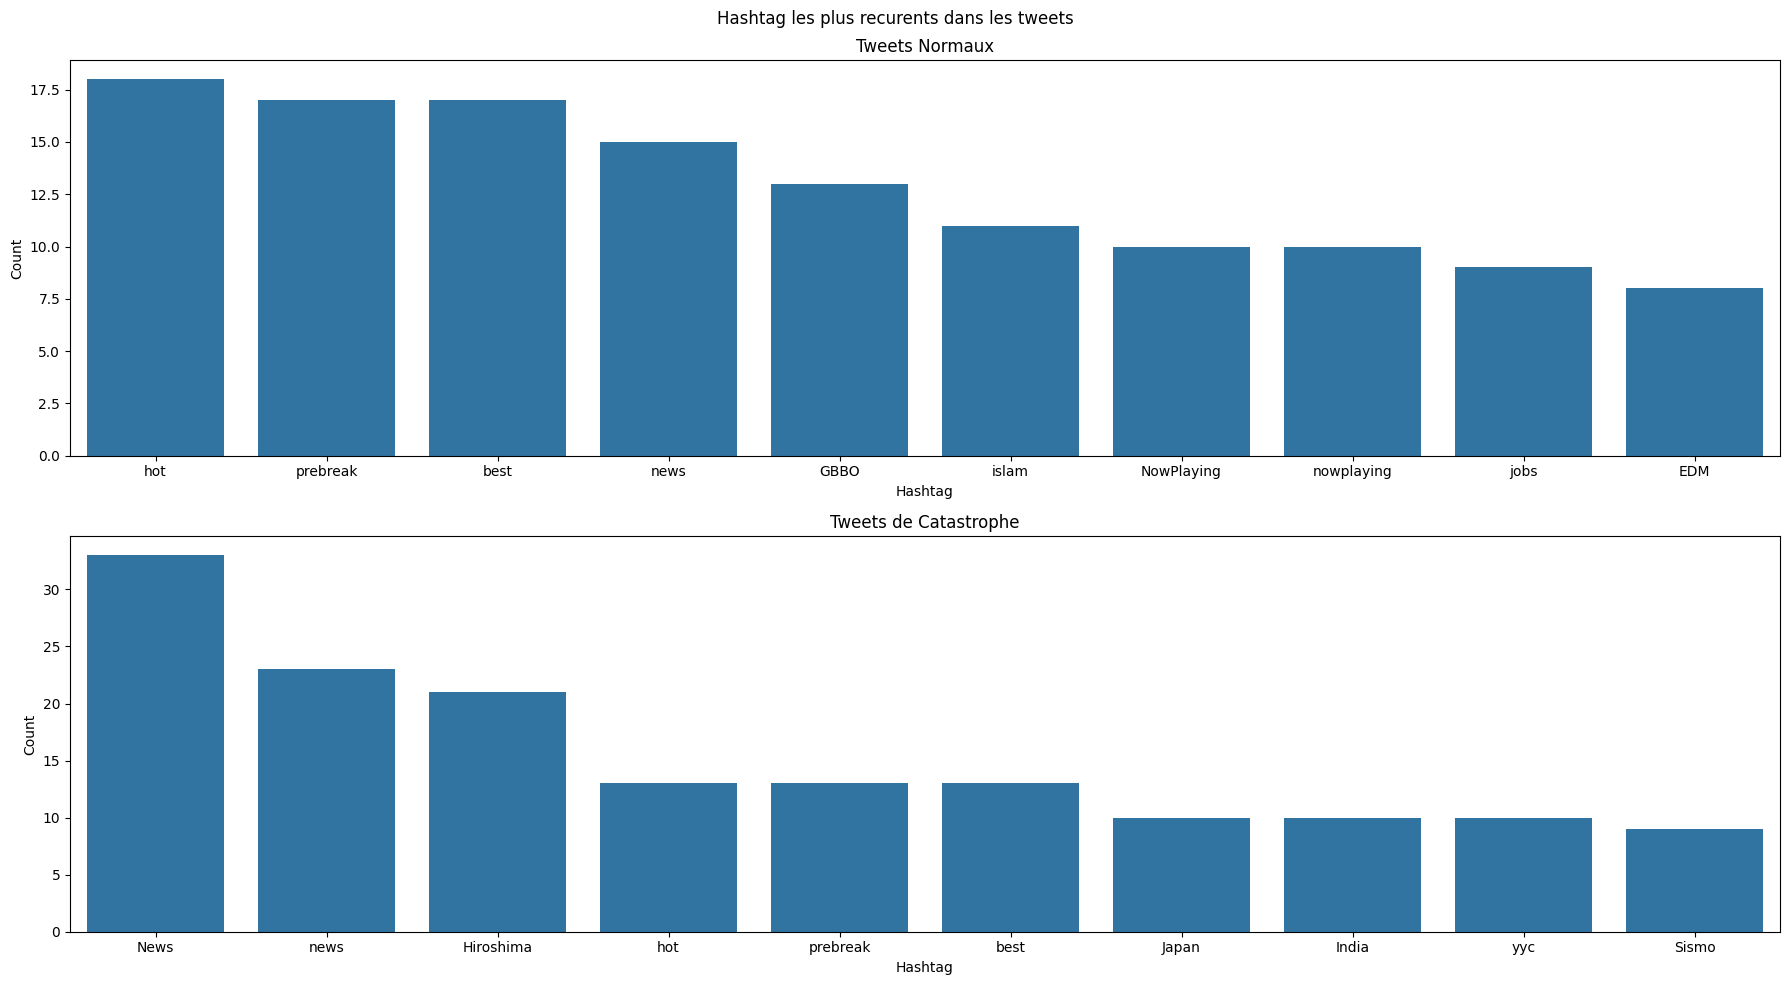

In [11]:

# Extraction des hashtags des tweets normaux
HT_regular = sum([re.findall(r"#(\w+)", tweet) for tweet in train_df['text'][train_df['target'] == 0]], [])

# Extraction des hashtags des tweets de catastrophe
HT_disaster = sum([re.findall(r"#(\w+)", tweet) for tweet in train_df['text'][train_df['target'] == 1]], [])

# Création des sous-graphiques
fig, axes = plt.subplots(2, 1, figsize=(18, 10))

# Tracer le graphique des hashtags pour les tweets normaux
freq_dist_regular = nltk.FreqDist(HT_regular)
df_regular = pd.DataFrame({'Hashtag': list(freq_dist_regular.keys()), 'Count': list(freq_dist_regular.values())})
df_regular = df_regular.nlargest(columns="Count", n=10)
sns.barplot(data=df_regular, x="Hashtag", y="Count", ax=axes[0]).set_title('Tweets Normaux')

# Tracer le graphique des hashtags pour les tweets de catastrophe
freq_dist_disaster = nltk.FreqDist(HT_disaster)
df_disaster = pd.DataFrame({'Hashtag': list(freq_dist_disaster.keys()), 'Count': list(freq_dist_disaster.values())})
df_disaster = df_disaster.nlargest(columns="Count", n=10)
sns.barplot(data=df_disaster, x="Hashtag", y="Count", ax=axes[1]).set_title('Tweets de Catastrophe')

fig.suptitle('Hashtag les plus recurents dans les tweets')

# Ajustement de l'espacement entre les sous-graphiques
plt.tight_layout()

# Affichage des graphiques
plt.show()

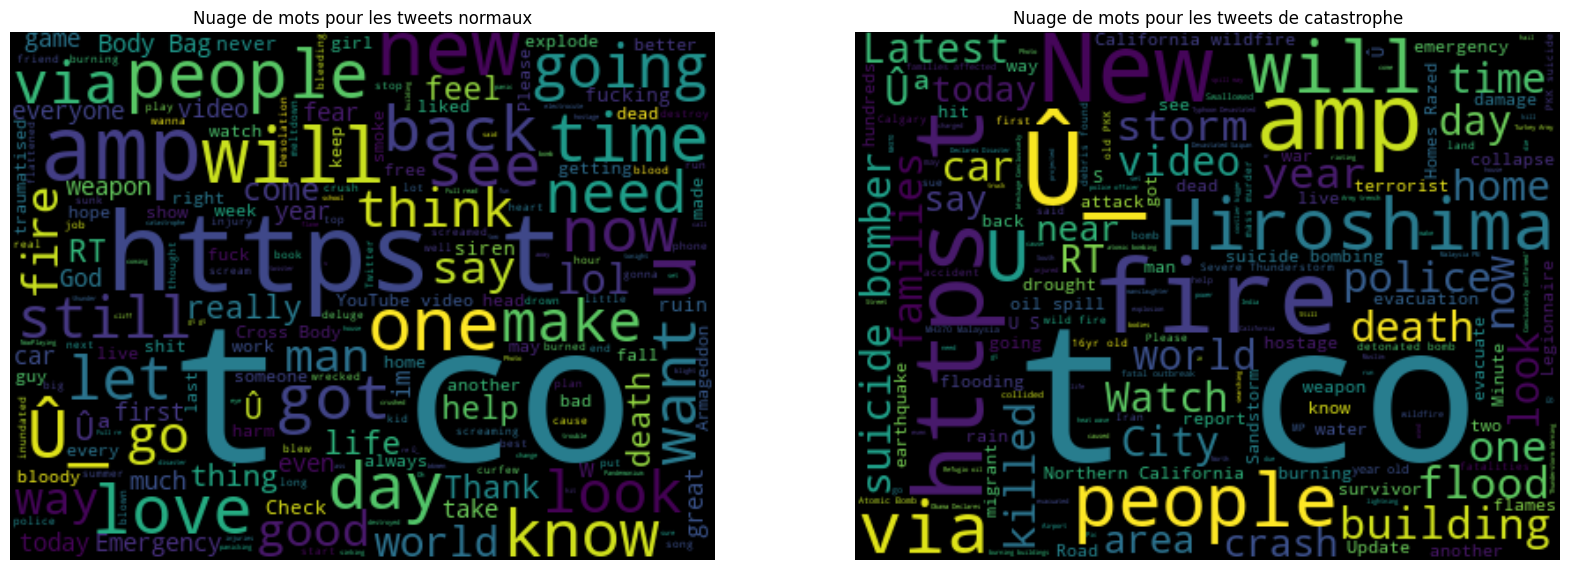

In [12]:
Merge_df =  pd.concat([train_df, test_df])


# Nuage de mots pour les tweets normaux
normal_words = ' '.join([text for text in Merge_df['text'][Merge_df['target'] == 0]])
wordcloud_normal = WordCloud(width=400, height=300, random_state=21, max_font_size=110).generate(normal_words)

# Nuage de mots pour les tweets de catastrophe
disaster_words = ' '.join([text for text in Merge_df['text'][Merge_df['target'] == 1]])
wordcloud_disaster = WordCloud(width=400, height=300, random_state=21, max_font_size=110).generate(disaster_words)

# Création de la figure et des sous-graphiques
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

# Affichage du nuage de mots pour les tweets normaux
axes[0].imshow(wordcloud_normal, interpolation="bilinear")
axes[0].set_title('Nuage de mots pour les tweets normaux')
axes[0].axis('off')

# Affichage du nuage de mots pour les tweets de catastrophe
axes[1].imshow(wordcloud_disaster, interpolation="bilinear")
axes[1].set_title('Nuage de mots pour les tweets de catastrophe')
axes[1].axis('off')

# Affichage de la figure
plt.show()

## Clean text


In [14]:

# Fusionner les données d'entraînement et de test
Merge_df =  pd.concat([train_df, test_df])

# Fonction pour supprimer les motifs spécifiés dans le texte
def remove_pattern(input_txt, pattern):
    regex_obj = re.compile(pattern)
    input_txt = regex_obj.sub(r'', input_txt)
    return input_txt

# Supprimer les noms d'utilisateur Twitter (@username)
Merge_df['text'] = Merge_df['text'].apply(lambda x: remove_pattern(x, "@[\w]*"))

#suprimer les #
Merge_df['text'] = Merge_df['text'].apply(lambda x: remove_pattern(x, "#"))

# Supprimer les URLs et les tags http
Merge_df['text'] = Merge_df['text'].apply(lambda x: remove_pattern(x, 'https?://\S+|www\.\S+'))
Merge_df['text'] = Merge_df['text'].apply(lambda x: remove_pattern(x, '<.*?>'))

# Supprimer la ponctuation, les caractères spéciaux et les chiffres
Merge_df['text'] = Merge_df['text'].apply(lambda x: remove_pattern(x, "[^a-zA-Z# ]"))

# Supprimer les mots vides (stop words)
stop = set(stopwords.words('english'))
def remove_stop_words(text):
    word_tokens = word_tokenize(text)
    filtered_sentence = [w for w in word_tokens if not w in stop]
    filtered_tweet = ' '.join(filtered_sentence)
    return filtered_tweet
Merge_df['text'] = Merge_df['text'].apply(lambda x: remove_stop_words(x))

# Supprimer les mots de moins de 3 caractères  !!!! Pas meilleur score sur kaggle mais meilleur score sur le test !!!!
Merge_df['text'] = Merge_df['text'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>2]))

#retirer la ponctuation
Merge_df['text'] = Merge_df['text'].str.replace('[^\w\s]','')

#spelling correction
Merge_df['text'][:5].apply(lambda x: str(TextBlob(x).correct()))

# Fonction pour tokeniser et raciniser (stemming) les mots
lemmatizer = WordNetLemmatizer()
def tokenize_stem(text):
    token_words = word_tokenize(text) #diviser le texte en mots individuels (tokens)
    stem_words = []
    for i in token_words:
        word = lemmatizer.lemmatize(i) #réduction des mots à leur forme de base ou de dictionnaire
        stem_words.append(word)
    final_tweet = ' '.join(stem_words) #reconstructuion du texte à partir des mots racinisés
    return final_tweet
Merge_df['text'] = Merge_df['text'].apply(lambda x: tokenize_stem(x))

In [15]:
#compte les lignes dupliquées
print('Nombre de lignes dupliquées : {}'.format(Merge_df.duplicated().sum()))

Nombre de lignes dupliquées : 0


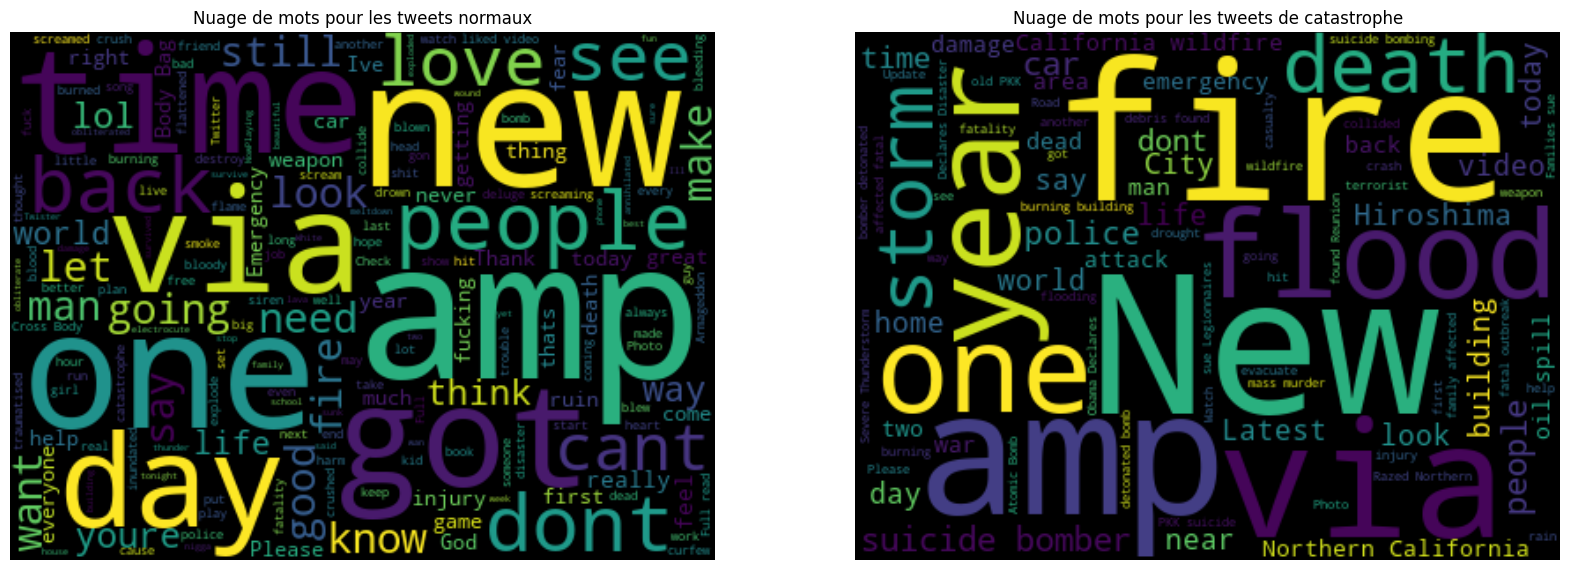

In [16]:
# Nuage de mots pour les tweets normaux
normal_words = ' '.join([text for text in Merge_df['text'][Merge_df['target'] == 0]])
wordcloud_normal = WordCloud(width=400, height=300, random_state=21, max_font_size=110).generate(normal_words)

# Nuage de mots pour les tweets de catastrophe
disaster_words = ' '.join([text for text in Merge_df['text'][Merge_df['target'] == 1]])
wordcloud_disaster = WordCloud(width=400, height=300, random_state=21, max_font_size=110).generate(disaster_words)

# Création de la figure et des sous-graphiques
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

# Affichage du nuage de mots pour les tweets normaux
axes[0].imshow(wordcloud_normal, interpolation="bilinear")
axes[0].set_title('Nuage de mots pour les tweets normaux')
axes[0].axis('off')

# Affichage du nuage de mots pour les tweets de catastrophe
axes[1].imshow(wordcloud_disaster, interpolation="bilinear")
axes[1].set_title('Nuage de mots pour les tweets de catastrophe')
axes[1].axis('off')

# Affichage de la figure
plt.show()

In [ ]:
train_df.head()

In [ ]:
Merge_df.head()

# Ajouter pour chaque mot un poid en fonction de s il apparait dans un tweet desastre ou non

In [17]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

train_data = Merge_df[~Merge_df['target'].isnull()]
test_data = Merge_df[Merge_df['target'].isnull()]

# Préparation des données
# Extraire les mots de chaque tweet et les marquer selon leur type (catastrophe ou non)
train_data['Word'] = train_data['text'].apply(lambda x: set(x.split()))
train_data['disaster'] = train_data['target'] == 1

# Création d'un seul ensemble pour tous les mots avec leur fréquence et type
all_words = train_data.explode('Word')
disaster_words = all_words[all_words['disaster']]['Word']
non_disaster_words = all_words[~all_words['disaster']]['Word']

# Calculer la fréquence des mots dans chaque catégorie
word_freq_disaster = disaster_words.value_counts()
word_freq_non_disaster = non_disaster_words.value_counts()

# Créer un dataframe pour manipuler les fréquences
word_freq_df = pd.DataFrame({
    'DisasterFreq': word_freq_disaster,
    'NonDisasterFreq': word_freq_non_disaster
}).fillna(0)  # Remplacer les NaN par 0 pour éviter les erreurs dans les calculs

# Calculer les fréquences totales
total_disaster = word_freq_df['DisasterFreq'].sum()
total_non_disaster = word_freq_df['NonDisasterFreq'].sum()

# Calculer les poids pour chaque mot
word_freq_df['Weight'] = 10000 * (
    (word_freq_df['DisasterFreq'] / total_disaster) -
    (word_freq_df['NonDisasterFreq'] / total_non_disaster)
)

# Trier les mots par poids
word_weights_df = word_freq_df[['Weight']].sort_values(by='Weight', ascending=False)

scaler = StandardScaler()
# Centrage et réduction des données du DataFrame
word_weights_df = pd.DataFrame(scaler.fit_transform(word_weights_df), columns=word_weights_df.columns)


# Afficher les 10 premiers mots les plus lourds
print(word_weights_df.head(10))

# Créer un fichier CSV à partir du DataFrame
word_weights_df.to_csv('word_weights.csv', columns=['Weight'])



      Weight
0  28.761630
1  22.032153
2  18.029794
3  17.888935
4  15.225967
5  14.926754
6  12.894734
7  12.852230
8  12.551335
9  12.435485


# Prédictions

In [18]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train_data.iloc[:, :-1], train_data['target'], test_size=0.2, random_state=0)


In [19]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Diviser les données en ensemble d'entraînement et ensemble de test
#train_data = Merge_df[~Merge_df['target'].isnull()]
#test_data = Merge_df[Merge_df['target'].isnull()]

# Créer le vecteur de fréquence de mots
count_vectorizer = CountVectorizer()
X_train_counts = count_vectorizer.fit_transform(X_train['text'])

# Appliquer la transformation TF-IDF
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

# Utiliser les poids calculés précédemment pour la transformation TF-IDF
# Vérifier que vous utilisez correctement les indices et les valeurs de votre DataFrame
word_weights = {word: weight for word, weight in zip(word_weights_df.index, word_weights_df['Weight'])}
feature_names = count_vectorizer.get_feature_names_out()
tfidf_transformer = TfidfTransformer(norm=None, smooth_idf=False)
tfidf_transformer.idf_ = [abs(word_weights.get(word, 1)) for word in feature_names]  # Fournir une valeur par défaut si le mot n'est pas dans word_weights

# Assurez-vous que la dimension de idf_ correspond à celle des features
assert len(tfidf_transformer.idf_) == len(feature_names), "Mismatch in dimension of IDF and feature names"

X_train_tfidf_weighted = tfidf_transformer.transform(X_train_counts)
#LogisticRegression
# MultinomialNB()
# RandomForestClassifier
# Entraîner le modèle Naive Bayes Multinomial
clf = LogisticRegression()
clf.fit(X_train_tfidf_weighted, y_train)


LogisticRegression()

In [20]:
# Prédire les cibles pour les lignes avec cible (ensemble d'entraînement)
X_train_counts = count_vectorizer.transform(X_test['text'])
X_train_tfidf = tfidf_transformer.transform(X_train_counts)
predicted_targets2 = clf.predict(X_train_tfidf)

# Calculer la précision du modèle
accuracy = np.mean(predicted_targets2 == y_test)
print(f"Accuracy: {accuracy}")

# Afficher la matrice de confusion
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(y_test, predicted_targets2)
print("Confusion Matrix:")
print(conf_matrix)

# Afficher les données mal prédites
misclassified_indices = np.where(predicted_targets2 != y_test)[0]
misclassified_texts = X_test.iloc[misclassified_indices]['text']
misclassified_targets = y_test.iloc[misclassified_indices]
misclassified_predictions = predicted_targets2[misclassified_indices]

# Créer un DataFrame avec les données mal prédites
misclassified_df = pd.DataFrame({
    'Text': misclassified_texts,
    'True Target': misclassified_targets,
    'Predicted Target': misclassified_predictions
})

# Afficher les premières lignes du DataFrame
misclassified_df.head()

#Accuracy: 0.8017071569271176


Accuracy: 0.8017071569271176
Confusion Matrix:
[[784 102]
 [200 437]]


,Text,True Target,Predicted Target
4970,People Near Meltdown Comics Who Have Free Time...,0.0,1.0
527,TIX Calgary Flames COL Avalanche Preseason Sco...,0.0,1.0
5056,Coming later year THE MAN THAT TATTOOED WOMEN ...,1.0,0.0
1531,Russian nuclearbiologicalchemical NBC brigade ...,1.0,0.0
5629,Short throwing overboard dont think leader cou...,1.0,0.0


In [ ]:
# Prédire les cibles pour les lignes sans cible
X_test_counts = count_vectorizer.transform(test_data['text'])
X_test_tfidf = tfidf_transformer.transform(X_test_counts)
predicted_targets = clf.predict(X_test_tfidf)

# Ajouter les prédictions au DataFrame des lignes sans cible en int
test_data['target'] = predicted_targets.astype(int)

# Stocker les lignes prédites dans un nouveau fichier (id et target)
submission = test_data[['id', 'target']]
submission.to_csv('submission.csv', index=False)

submission.head(10)
